# Oefentoets Computational Modelling
Deze oefentoets bestaat uit twee opdrachten met verschillende opgaven per opdracht. In de eerste opdracht gaan jullie aan de slag met het verkennen van een dataset en in de tweede opdracht met unsupervised learning. Voor deze oefentoets hebben jullie 60 minuten de tijd.

Lees de instructies hieronder goed door.

### Beantwoorden vragen
Licht jouw uitwerking toe. Documenteer belangrijke stukken code en licht jouw werkwijze toe. 

#### Code documenteren
Simpele code zoals het aanmaken van een leeg array of een train_test_split functie aanroepen hoeft niet toegelicht te worden, maar wanneer je iets doet dat belangrijk is om te begrijpen omdat het essentieel is voor de opdracht moet toegelicht worden. Leg dit uit m.b.v. commentaar bij de code.

#### Werkwijze toelichten
Om tot een oplossing te komen, voer je vaak meerdere stappen uit. Leg uit welke stappen je uitvoert, waarom deze stappen nodig zijn, de volgorde, etc. Gebruik hier voor een aparte 'Markdown' cel.

## Opdracht 1
In deze opdracht gaan jullie een dataset verkennen. We gebruiken hiervoor de IMDB movieset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy.stats as stats
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
df = pd.read_csv('movie.csv')
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [3]:
df["duration"] = df["duration"].fillna(df["duration"].mean())
df["gross"] = df["gross"].fillna(df["gross"].mean())
df["budget"] = df["budget"].fillna(df["budget"].mean())
df["imdb_score"] = df["imdb_score"].fillna(df["imdb_score"].mean())

### Outliers
In de onderstaande vier boxplots is er duidelijk te zien dat er veel outliers zijn. Ook is het duidelijk dat de meeste outliers allemaal onder het gemiddelde liggen, en bij de "Gross" zelfs niks boven het gemiddelde uitschiet. Hier is tevens te zien dat deze kolom de meeste en extreme uitschieters heeft.

In [4]:
for column in ["duration", "gross", "budget", "imdb_score"]:
    median = np.median(df[column])
    q1 = np.percentile(df[column], 25)
    q3 = np.percentile(df[column], 75)
    iqr = q3 - q1

    outliers = df[(df[column] < q1 - 1.5 * iqr) | (df[column] > q3 + 1.5 * iqr)]

<Axes: xlabel='duration'>

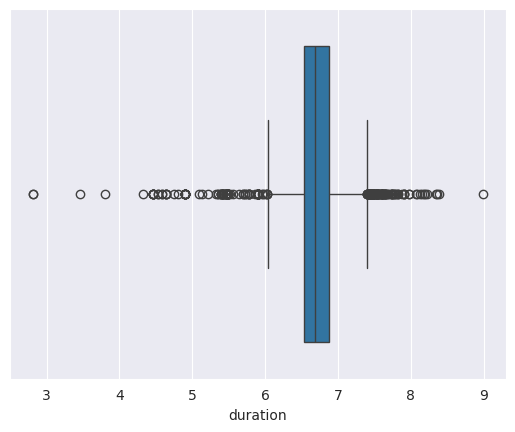

In [5]:
sns.boxplot(x=np.log2(df["duration"]))

<Axes: xlabel='gross'>

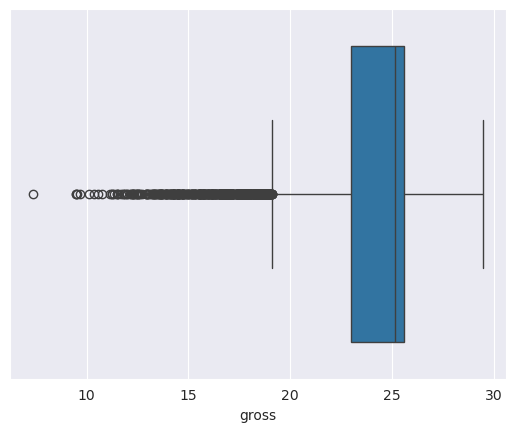

In [6]:
sns.boxplot(x=np.log2(df["gross"]))

<Axes: xlabel='budget'>

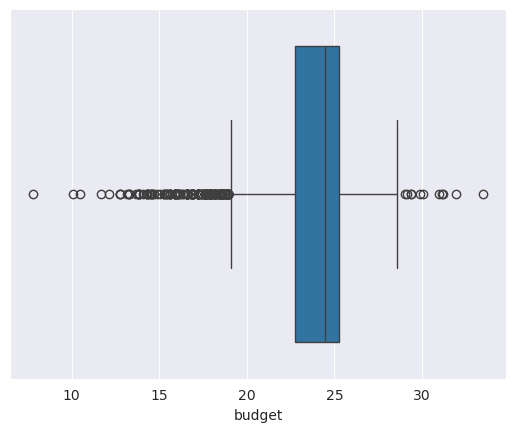

In [7]:
sns.boxplot(x=np.log2(df["budget"]))

<Axes: xlabel='imdb_score'>

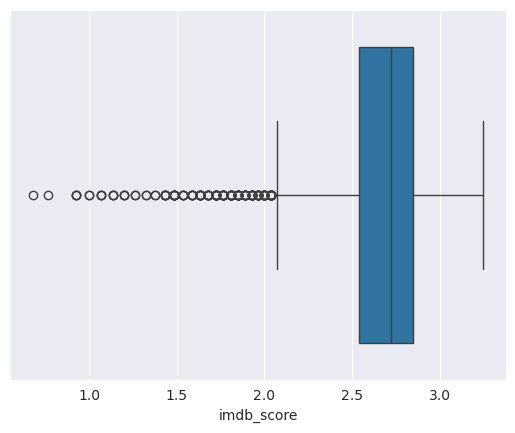

In [8]:
sns.boxplot(x=np.log2(df["imdb_score"]))

**Opgave 1.2.**

Bepaal de correlatie tussen de kolommen `['duration','gross','budget', 'imdb_score']` onderling. Tussen welke twee kolommen is de correlatie het sterkste? Is hier sprake van een sterke correlatie?

### Correlation
Bij het uitzoeken van de correlatie tussen de kolomen is het duidelijk geworden dat alle kolomen niet een groot verband met elkaar hebben. Ondanks deze uitkomst is het wel zichtbaar dat de kolomen "Duration" en "imdb_score" het meest met elkaar te maken hebben.

In [9]:
df[["duration", "gross", "budget", "imdb_score"]].corr(method="pearson")

,duration,gross,budget,imdb_score
duration,1.000000,0.204975,0.064412,0.260886
gross,0.204975,1.000000,0.101437,0.168169
budget,0.064412,0.101437,1.000000,0.028905
imdb_score,0.260886,0.168169,0.028905,1.000000


<Axes: xlabel='duration', ylabel='imdb_score'>

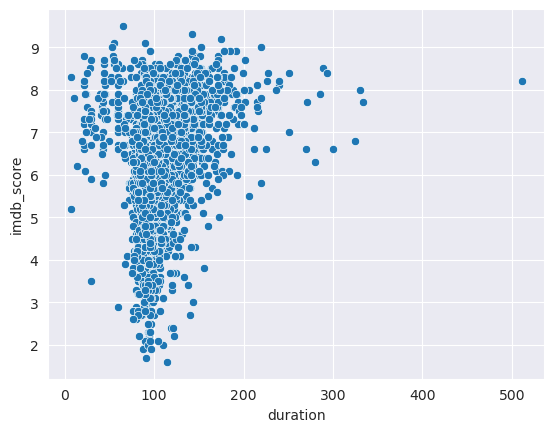

In [10]:
sns.scatterplot(df[["duration", "imdb_score"]], x="duration", y="imdb_score")

**Opgave 1.3.**

Bepaal de volgende kansen:
1. Hoe groot is de kans dat wanneer ik een willekeurige film kies, de `imdb_score` van deze film groter is dan 9.0?
2. Hoe groot is de kans dat wanneer ik een willekeurige film kies, de `duration` tussen 3 en 4 uur zal liggen?

Je mag dit handmatig bepalen met een Z-tabel of met Python code.

In [11]:
mean_imdb = df['imdb_score'].mean()
std_imdb = df['imdb_score'].std()

prob_imdb_greater_9 = 1 - stats.norm.cdf(9.0, loc=mean_imdb, scale=std_imdb)
print(f"Probability greater than 9\n{prob_imdb_greater_9:.4f}")

Probability greater than 9
0.0115


In [12]:
mean_duration = df['duration'].mean()
std_duration = df['duration'].std()

duration_3_hours = 3 * 60
duration_4_hours = 4 * 60

prob_duration_3_to_4_hours = stats.norm.cdf(duration_4_hours, loc=mean_duration, scale=std_duration) - stats.norm.cdf(duration_3_hours, loc=mean_duration, scale=std_duration)
print(f"Probability between 3 and 4\n{prob_duration_3_to_4_hours:.4f}")

Probability between 3 and 4
0.0019


**Opgave 1.4.**

Toon de volgende gegevens:

1. Een overzicht van de gemiddelde IMDB scores per regisseur, aflopend gesorteerd
2. Een overzicht van de drie films met de langste duur
3. Een overzicht van de duur en IMDB score van alle Franstalige films (`language = 'French'`) uit 2014 en 2015
4. Uitbreiding op vraag 3: toon de gemiddelde duur en IMDB score van deze films

In [13]:
df.groupby(["director_name"])["imdb_score"].mean().sort_values(ascending=False).head()

df[["director_name", "imdb_score"]].groupby(["director_name"]).agg("mean").sort_values(by="imdb_score", ascending=False).head()

,imdb_score
director_name,
John Blanchard,9.5
Mitchell Altieri,8.7
Sadyk Sher-Niyaz,8.7
Cary Bell,8.7
Mike Mayhall,8.6


In [14]:
df.sort_values(["duration"], ascending=False).iloc[:3]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
1710,Color,NaN,16.0,511.0,NaN,51.0,Ingvar Eggert Sigurðsson,147.0,4.846841e+07,Crime|Drama|Thriller,...,19.0,Icelandic,Iceland,NaN,3.975262e+07,NaN,63.0,8.2,16.00,0
2466,Color,NaN,108.0,334.0,NaN,30.0,Nora von Waldstätten,897.0,1.451180e+05,Biography|Crime|Drama|Thriller,...,36.0,English,France,Not Rated,3.975262e+07,NaN,30.0,7.7,2.35,0
1501,Color,Taylor Hackford,12.0,330.0,138.0,672.0,Jesse Borrego,848.0,4.496583e+06,Crime|Drama,...,129.0,English,USA,R,3.500000e+07,1993.0,674.0,8.0,1.66,6000


In [15]:
df[
    ['duration', 'imdb_score']
][
    (df["language"] == "French") & 
    (df["title_year"] >= 2014.0) &
    (df["title_year"] <= 2015.0)
].head()

,duration,imdb_score
489,81.0,6.4
1178,101.0,4.9
3088,106.0,7.4
3313,98.0,6.1
3437,101.0,7.3


In [16]:
df[
    (df["language"] == "French") &
    (df["title_year"] >= 2013.0) &
    (df["title_year"] <= 2014.0)
][
    ['duration', 'imdb_score']
].mean()

duration      95.250
imdb_score     6.775
dtype: float64

## Opdracht 2
In deze opdracht gaan jullie een model trainen met behulp van unsupervised learning.

In [17]:
X, y_true = make_blobs(n_samples=400, centers=7,
                       cluster_std=0.90, random_state=0)
df = pd.DataFrame(X)

**Opgave 2.1.**

Maak een scatterplot van de waardes uit array `X`

<Axes: >

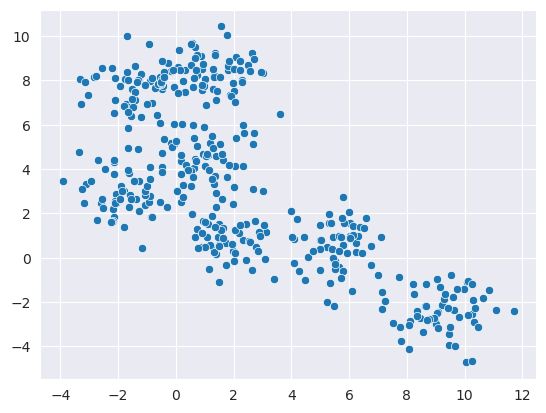

In [18]:
sns.scatterplot(x=X[:, 0], y=X[:, 1])

**Opgave 2.2.**

Gebruik `KMeans` om een clustering te maken van de punten in array `X`. Kies voor `k` = 5.

In [19]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

**Opgave 2.3.**

Bepaal de score van gevonden clustering.

In [20]:
kmeans.score(X)

-1081.222314259273

In [21]:
df[2] = kmeans.labels_
df.head()

,0,1,2
0,1.266982,7.622731,1
1,9.617714,-2.361988,2
2,6.032059,0.931655,4
3,-2.149749,4.300622,3
4,8.357018,-2.401239,2


**Opgave 2.4.**

Pas de scatterplot van opgave 2.1 aan en visualiseer de gevonden clusters.

<Axes: >

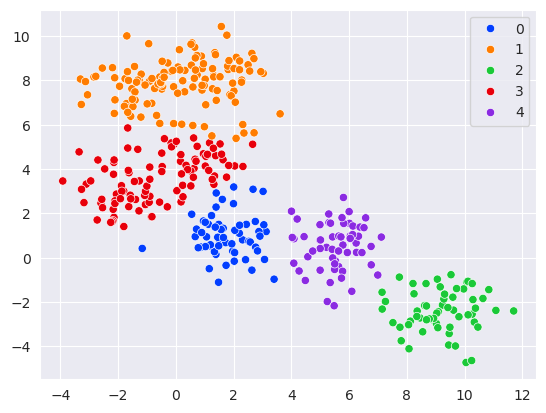

In [22]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans.labels_, palette='bright')

**Opgave 2.5.**

Maak een clustering voor `k` = 1 t/m 20. Geef aan voor welke `k` de clustering het _beste_ is. Onderbouw wat je onder het _beste_ verstaat.

<Axes: >

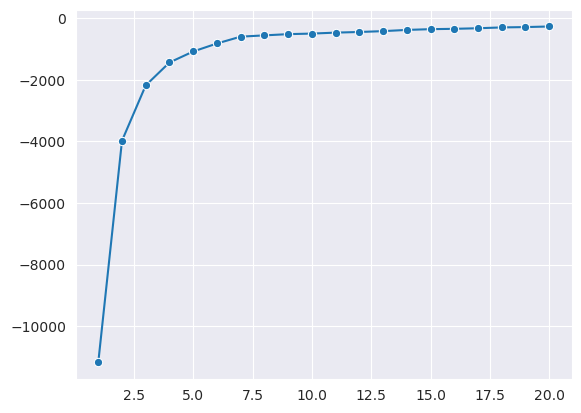

In [23]:
inertia = []

k_range = range(1, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertia.append(kmeans.score(X))

sns.lineplot(x=k_range, y=inertia, marker="o")

In [24]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)

**Opgave 2.6.**

Maak ook een clustering met `GaussianMixture` met de in opgave 2.5 gekozen `k`. 

In [25]:
gmm = GaussianMixture(n_components=7, covariance_type="full").fit(X)

In [26]:
df[3] = gmm.predict(X)
df.head()

,0,1,2,3
0,1.266982,7.622731,1,0
1,9.617714,-2.361988,2,1
2,6.032059,0.931655,4,5
3,-2.149749,4.300622,3,4
4,8.357018,-2.401239,2,1


<Axes: >

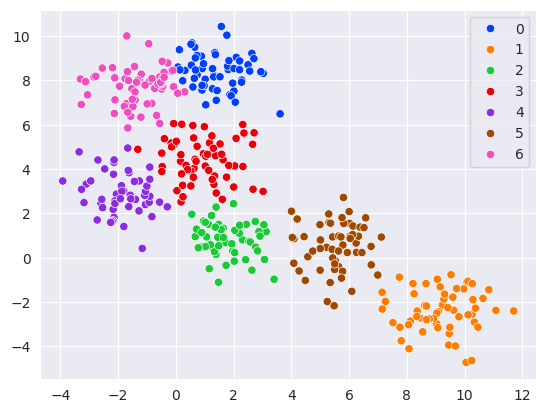

In [27]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=gmm.predict(X), palette='bright')

**Opgave 2.7.**

Ga op zoek naar punten uit `X` die voor `KMeans` en `GaussianMixture` in verschillende clusters zijn ingedeeld. Kies één punt en verklaar waarom de clustering afwijkt. 

In [28]:
different_clusters = df[df[2] != df[3]]

point_index = different_clusters.index[0]
point = X[point_index]
kmeans_cluster = df.loc[point_index, 2]
gmm_cluster = df.loc[point_index, 3]

print(f"Point {point} is in cluster {kmeans_cluster} with KMeans and in cluster {gmm_cluster} with GaussianMixture.")

Point [1.26698208 7.62273102] is in cluster 1 with KMeans and in cluster 0 with GaussianMixture.


## Einde toets
Voer `Restart & Run All` uit onder `Kernel` en check of er geen errors zijn.